In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

print(torch.cuda.is_available())

True


## 2D Poisson equation

$$ \nabla^2 u(x, y) = f(x, y) $$

Here we will make $f(x, y)$ the convolution of some point source distribution $\rho(x, y)$ with a gaussian kernel

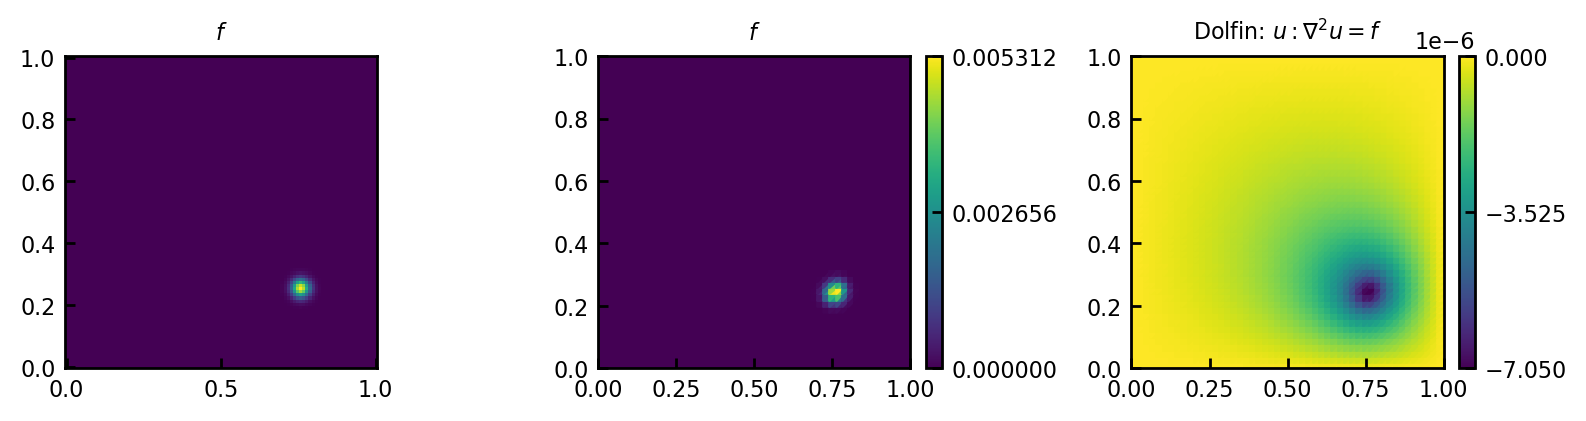

In [132]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

inputs[2] = 0.
inputs[2, 25, 75] = 1.

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    force = gaussian_filter(xyc[2:], sigma=2) * np.sin(xyc[0:1]) * np.sin(xyc[1:2])
    return force

mesh_size = 50
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

F = forcing_function(inputs)
force = multichannel_img_to_mesh(F, X, Y, build_problem.function_space, return_function=True)

dlf_sol = build_problem.forward(force)

# Plot and compare
fig, ax = plt.subplots(1, 3, figsize=(8,2.5))
ax = ax.flatten()

# Forcing function
ax[0].pcolormesh(X, Y, F.squeeze())
ax[0].set_title(r'$f$')

plot_mesh(force.compute_vertex_values(), mesh, ax[1])
ax[1].set_title(r'$f$')

# Dolfin solutions
plot_mesh(dlf_sol.compute_vertex_values(), mesh, ax[2])
ax[2].set_title(r'Dolfin: $u: \nabla^2 u = f$')

for a in ax:
    a.set_aspect('equal')

plt.tight_layout()

In [133]:
import h5py
from tqdm import trange

dataset_size = 1024
mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

with h5py.File('poisson_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.create_dataset('mesh_size', data=mesh_size)
    h5f.create_dataset('dataset_size', data=dataset_size)

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 1, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        inputs[2] = 0.
        for j in range(5):
            inputs[2, np.random.randint(25, 75), np.random.randint(25, 75)] += 1.

        force = forcing_function(inputs)
        force_mesh = multichannel_img_to_mesh(
            force, 
            X, 
            Y, 
            build_problem.function_space, 
            return_function=True)
        
        output = build_problem.forward(force_mesh).compute_vertex_values()

        h5f['inputs'][i] = inputs
        h5f['forces'][i] = force
        h5f['outputs'][i] = output



Opened file for writing


100%|██████████| 1024/1024 [00:16<00:00, 63.18it/s]


30


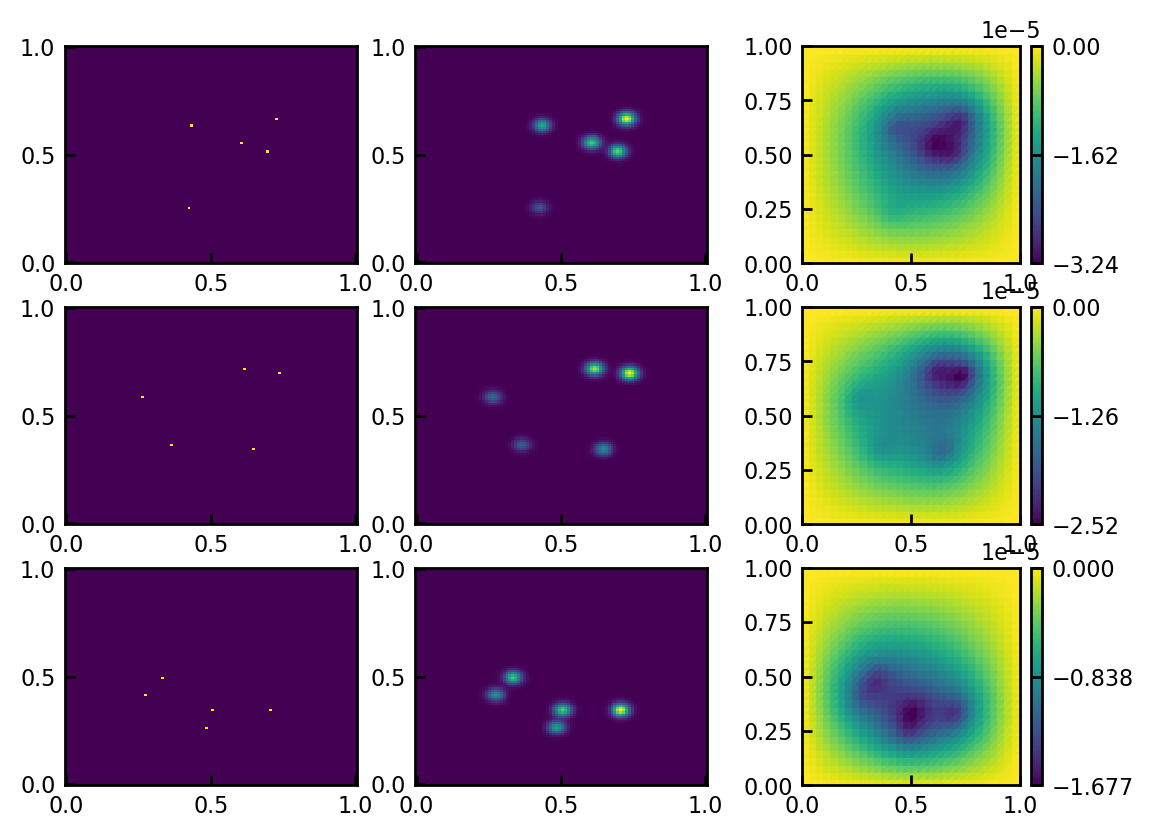

In [134]:
fig, ax = plt.subplots(3, 3)

with h5py.File('poisson_dataset.hdf5', 'r') as h5f:
    print(h5f['mesh_size'][()])
    mesh = d_ad.UnitSquareMesh(nx=h5f['mesh_size'][()], ny=h5f['mesh_size'][()])

    for i in range(3):
        inputs = h5f['inputs'][i]
        ax[i, 0].pcolormesh(inputs[0], inputs[1], inputs[2])
        ax[i, 1].pcolormesh(inputs[0], inputs[1], h5f['forces'][i, 0])
        plot_mesh(h5f['outputs'][i], mesh, ax[i, 2])

## 2D Incompressible Stokes equation

$$ \nabla^2 \mathbf{v} - \nabla p + \mathbf{f} = 0 $$

Subject to the incompressibility condition $\nabla \cdot \mathbf{v} = 0$

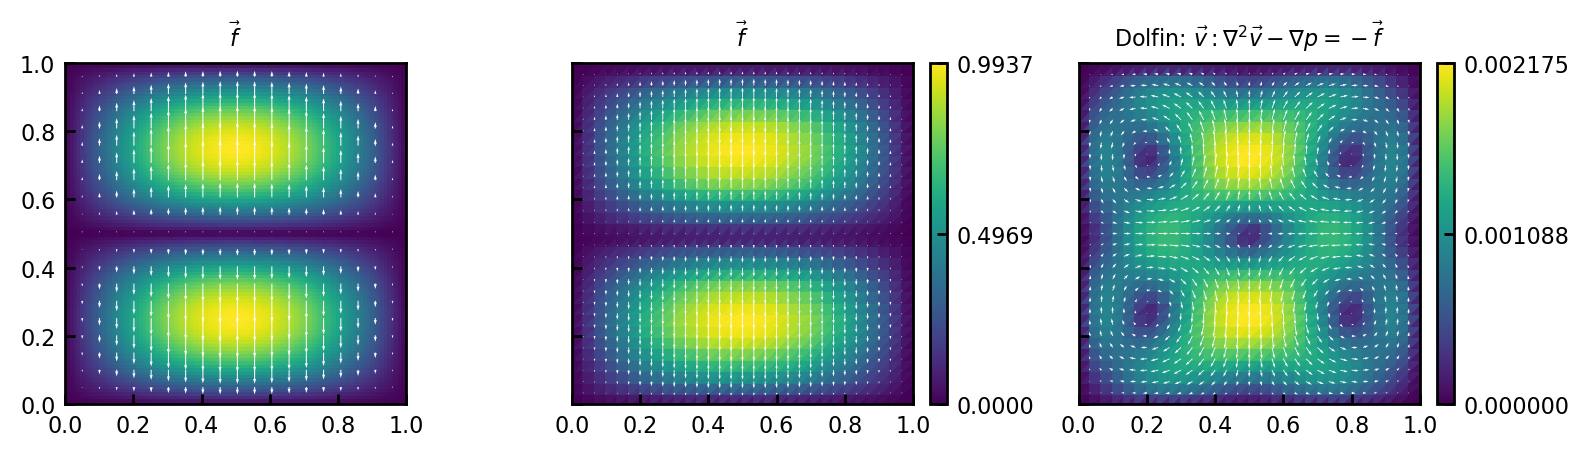

In [135]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import BuildStokesProblem

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')

C = np.zeros([2, *X.shape])
C[1] = -np.sin(Y * (2 * np.pi)) * np.sin(X * np.pi)
inputs = np.concatenate([X[None], Y[None], C], axis=0)

mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildStokesProblem(mesh)

force = multichannel_img_to_mesh(
    inputs[2:], 
    X, 
    Y, 
    build_problem.function_space, 
    return_function=True)
dlf_sol = build_problem.forward(force)

# Plot and compare
fig, ax = plt.subplots(1, 3, figsize=(8,2.5), sharex=True, sharey=True)
ax = ax.flatten()

# Forcing function
skip = 5
slc = np.s_[::skip, ::skip]
ax[0].pcolormesh(inputs[0], inputs[1], np.linalg.norm(inputs[2:], axis=0))
ax[0].quiver(inputs[0][slc], inputs[1][slc], inputs[2][slc], inputs[3][slc], color='white')
ax[0].set_title(r'$\vec{f}$')

force = force.compute_vertex_values().reshape([2, -1])
plot_mesh(np.linalg.norm(force, axis=0), mesh, ax[1])
ax[1].quiver(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], 
             force[0], force[1],
             color='white')
ax[1].set_title(r'$\vec{f}$')

# Dolfin solutions
dlf_sol = dlf_sol.compute_vertex_values().reshape([2, -1])
plot_mesh(np.linalg.norm(dlf_sol, axis=0), mesh, ax[2])
ax[2].quiver(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], 
             dlf_sol[0], dlf_sol[1],
             color='white')
ax[2].set_title(r'Dolfin: $\vec{v}: \nabla^2 \vec{v} - \nabla p = -\vec{f}$')

for a in ax:
    a.set_aspect('equal')

plt.tight_layout()

## 2D Elasticity + Adhesion equation

$$ U = \int dA\, \bigg[ \frac{h}{2} \big( \sigma_{ij}^{el} + \sigma^a \delta_{ij} \big)  u_{ij} + \frac{1}{2} Y(x) \mathbf{u}^2 \bigg] $$

The coefficient $\mathbf{Y}(x)$ is a tunable parameter field that determines adhesion stiffness. Here the elastic stress obeys the constitutive relation:

$$ \sigma_{ij}^{el} = \frac{E}{1 + \nu} \bigg( u_{ij} + \frac{\nu}{1 - 2\nu} u_{kk} \delta_{ij} \bigg) $$

Where $E$ is the Young's modulus and $\nu$ is the Poisson ratio of the material. Minimization of this energy leads to the partial differential equations

$$ h \partial_{ij} \sigma_{ij}^{el} = Y(x) u_i \quad \text{(bulk)} $$ 
$$ \sigma_{ij}^{el} n_j = -\sigma_a n_i \quad \text{(boundary)} $$

For this problem, we take a circular domain and consider localized regions of large $Y(x)$. Other coefficients are taken to be known and fixed constants

In [56]:
import pygmsh
import meshio

with pygmsh.geo.Geometry() as geom:
    print(geom)
    geom.add_circle((0.5, 0.5), radius=0.4, mesh_size=0.02)
    mesh = geom.generate_mesh(dim=2)

print(mesh)
mesh = meshio.Mesh(
    points=mesh.points[:, :2],
    cells=[("triangle", mesh.cells_dict["triangle"])]
)
meshio.write('circle_mesh.xml', mesh)

mesh = dlf.Mesh('circle_mesh.xml')

mesh

<pygmsh Geometry object>
<meshio mesh object>
  Number of points: 6015
  Number of cells:
    line: 252
    triangle: 11774
    vertex: 4


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

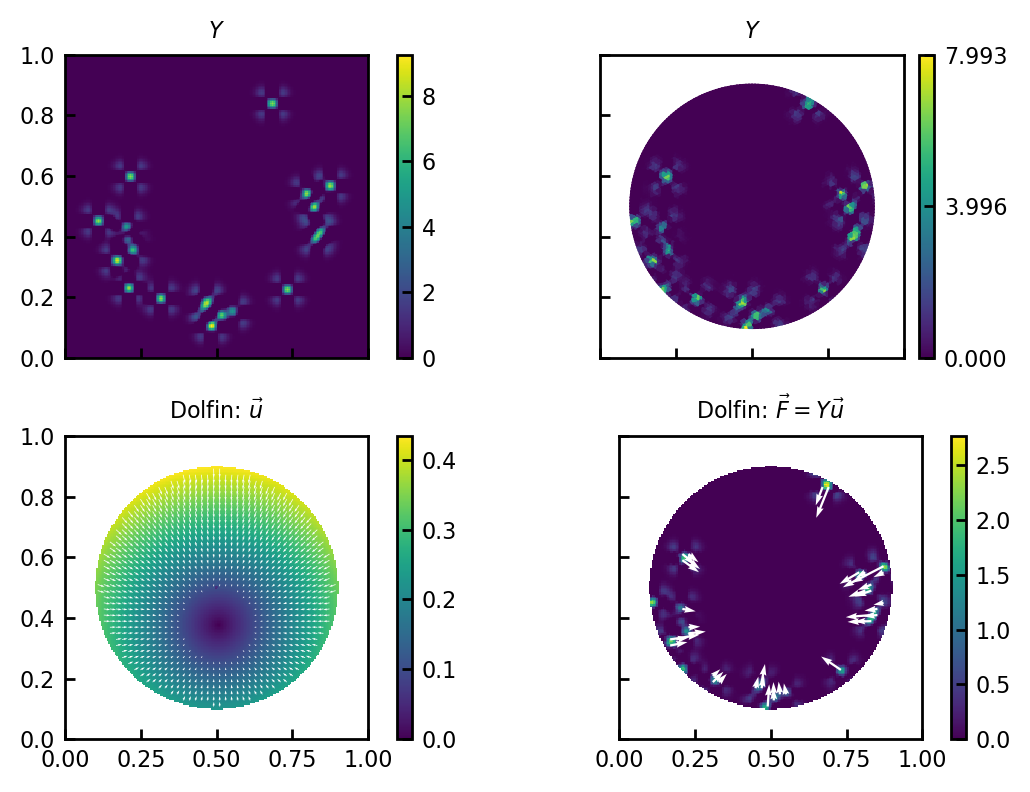

In [130]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import BuildElasticityAdhesionProblem

X = np.linspace(0, 1, 200)
Y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(X, Y, indexing='xy')

# Dolfin solutions
from scipy.interpolate import griddata
from skimage.transform import downscale_local_mean

def plot_dolfin_vector(ax, mesh_vals, downscale=4, threshold=0.1):
    mesh_xy = (mesh.coordinates()[:, 0], mesh.coordinates()[:, 1])
    grid_xy = (X, Y)
    grid_vals = np.zeros([2, *X.shape])

    grid_vals[0] = griddata(mesh_xy, mesh_vals[0], grid_xy)
    grid_vals[1] = griddata(mesh_xy, mesh_vals[1], grid_xy)

    grid_norm = np.linalg.norm(grid_vals, axis=0)
    im = ax.pcolormesh(X, Y, grid_norm, vmin=0)
    plt.colorbar(im, ax=ax)

    grid_vals = np.stack([
        downscale_local_mean(grid_vals[0], (downscale, downscale)),
        downscale_local_mean(grid_vals[1], (downscale, downscale)),
    ])
    grid_norm = np.linalg.norm(grid_vals, axis=0)
    mask = grid_norm >= threshold

    X_grid = downscale_local_mean(X, (downscale, downscale))
    Y_grid = downscale_local_mean(Y, (downscale, downscale))

    ax.quiver(X_grid[mask], Y_grid[mask], grid_vals[0, mask], grid_vals[1, mask], color='white')

r = np.sqrt((X - 0.5)**2 + (Y - 0.5)**2)
mask = r < 0.4

C = np.zeros(X.shape)
#C[mask] = 0.1

allowed = np.argwhere(np.logical_and(mask, r > 0.3))
for j in range(20):
    idx = np.random.randint(0, len(allowed))
    point = allowed[idx]
    C[point[0], point[1]] += 10.

inputs = np.stack([X, Y, C], axis=0)

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    inp = xyc[2:]
    Y = 5e8 * -gaussian_filter(inp, sigma=4, order=2)
    Y[Y < 0] = 0.
    return Y

mesh = dlf.Mesh('circle_mesh.xml')
build_problem = BuildElasticityAdhesionProblem(mesh)

Y_grid = forcing_function(inputs)
Y_func = multichannel_img_to_mesh(Y_grid, X, Y, build_problem.function_space, return_function=True)

u_func = build_problem.forward(Y_func)
F_func = Y_func * u_func

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
ax = ax.flatten()

# Forcing function
im = ax[0].pcolormesh(X, Y, Y_grid.squeeze(), vmin=0)
plt.colorbar(im, ax=ax[0])
ax[0].set_title(r'$Y$')

Y_mesh = Y_func.compute_vertex_values()
plot_mesh(Y_mesh, mesh, ax[1], vmin=0)
ax[1].set_title(r'$Y$')

u_mesh = u_func.compute_vertex_values().reshape([2, -1])

plot_dolfin_vector(ax[2], u_mesh)
ax[2].set_title(r'Dolfin: $\vec{u}$')

plot_dolfin_vector(ax[3], Y_mesh * u_mesh, downscale=4, threshold=0.5)
ax[3].set_title(r'Dolfin: $\vec{F} = Y \vec{u}$')


for a in ax:
    a.set(xlim=[0, 1], ylim=[0, 1])
    a.set_aspect('equal')

plt.tight_layout()